<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/9x.ml_highspeed_networks/Training%20and%20testing%20an%20MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLosses


# The following is to be able to mount Google Drive
from google.colab import drive


# We import a function I prepared for you in the course library
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


from typing import List

--2020-05-18 14:50:52--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.70K  --.-KB/s    in 0.001s  

2020-05-18 14:50:52 (12.4 MB/s) - ‘visualization.py’ saved [13008/13008]



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Download the dataset and train/test split

Load the dataset

In [2]:
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/fulldataset.csv


--2020-05-18 14:14:20--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261162 (255K) [text/plain]
Saving to: ‘lowdataset.csv’

lowdataset.csv      100%[===================>] 255.04K  --.-KB/s    in 0.05s   

2020-05-18 14:14:20 (4.84 MB/s) - ‘lowdataset.csv’ saved [261162/261162]

--2020-05-18 14:14:23--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connec

In [3]:
! ls

fulldataset.csv  highdataset.csv  lowdataset.csv  sample_data


In [4]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

data = full_df.to_numpy()
print (data)

[[1.00049514e+00 1.03077728e+08 1.23124322e+09 ... 2.58867891e+09
  1.00033176e+03 2.00000000e+00]
 [2.00077842e+00 1.03101759e+08 1.23279932e+09 ... 2.58855446e+09
  1.00027918e+03 2.00000000e+00]
 [3.00103663e+00 1.02770344e+08 1.23782341e+09 ... 2.58852670e+09
  1.00023441e+03 2.00000000e+00]
 ...
 [2.70220397e+01 5.47615400e+06 1.94312134e+09 ... 2.58890188e+09
  1.00023598e+03 0.00000000e+00]
 [2.80222923e+01 5.48787400e+06 1.94338561e+09 ... 2.58887486e+09
  1.00023823e+03 0.00000000e+00]
 [2.90225439e+01 5.49727500e+06 1.94272972e+09 ... 2.58887145e+09
  1.00022864e+03 0.00000000e+00]]


In [5]:
full_df.head()

,time,L1-dcache-load-misses,L1-dcache-loads,L1-dcache-stores,L1-icache-load-misses,LLC-load-misses,LLC-loads,LLC-store-misses,LLC-stores,branch-load-misses,branch-misses,branches,bus-cycles,cache-misses,cache-references,context-switches,cpu-clock,cycles,dTLB-load-misses,dTLB-store-misses,dTLB-stores,iTLB-load-misses,iTLB-loads,instructions,minor-faults,node-load-misses,node-loads,node-store-misses,node-stores,page-faults,ref-cycles,task-clock,label
0,1.000495,103077728.0,1.231243e+09,898826152.0,72883.0,5839.0,67744732.0,2342.0,18527710.0,7807489.0,7886979.0,628881534.0,99552660.0,8737.0,86426321.0,0.0,1000.331787,2.588345e+09,2037420.0,1125.0,896680176.0,6564.0,65.0,4.156039e+09,0.0,2042.0,3702.0,347.0,2070.0,0.0,2.588679e+09,1000.331761,2
1,2.000778,103101759.0,1.232799e+09,905120554.0,74731.0,4571.0,67881423.0,2362.0,18554828.0,9133385.0,9165031.0,625981553.0,99547137.0,7102.0,86473425.0,0.0,1000.282500,2.588267e+09,1761197.0,850.0,900898809.0,6452.0,17.0,4.145298e+09,0.0,2057.0,2426.0,288.0,1988.0,0.0,2.588554e+09,1000.279182,2
2,3.001037,102770344.0,1.237823e+09,899330524.0,71705.0,4151.0,67815941.0,2392.0,18520769.0,8287877.0,8327272.0,628893346.0,99545309.0,6302.0,86445289.0,1.0,1000.234177,2.588165e+09,2273062.0,800.0,897296903.0,6858.0,50.0,4.167709e+09,0.0,2141.0,1678.0,278.0,2112.0,0.0,2.588527e+09,1000.234405,2
3,4.001291,102978552.0,1.238686e+09,896826652.0,72874.0,3564.0,67792090.0,2341.0,18533209.0,7735405.0,7619128.0,629780640.0,99547593.0,5947.0,86563931.0,0.0,1000.238555,2.588264e+09,2157620.0,1000.0,898206667.0,7405.0,46.0,4.175008e+09,0.0,2336.0,1478.0,350.0,2038.0,0.0,2.588566e+09,1000.238518,2
4,5.001552,103130303.0,1.233340e+09,904715733.0,73539.0,3078.0,67095884.0,2344.0,18528084.0,8670019.0,8614560.0,627457256.0,99546692.0,5607.0,86487874.0,0.0,1000.249457,2.588232e+09,2279698.0,1113.0,896643768.0,6489.0,42.0,4.161144e+09,20.0,2063.0,1263.0,288.0,2125.0,20.0,2.588545e+09,1000.249625,2


In [6]:
print("samples and columns", full_df.shape)
print("Possible labels ", np.unique(full_df['label']) )

samples and columns (2610, 33)
Possible labels  [0 1 2]


In [7]:
def train_validation_test_splits(data, train_size, validation_size):
    assert(train_size + validation_size < 1.0)
    # shuffling of the dataset
    np.random.shuffle(data)
    # extract the training portion
    n = int(train_size * len(data))
    train, rest = data[:n,:], data[n:,:]
    # from the remaining examples, we extract the validation and test portions
    n = int(validation_size * len(data))
    validation, test = rest[:n,:], rest[n:,:]
    return train, validation, test

train, validation, test = train_validation_test_splits(data, 0.8, 0.1)

print('The number of examples in the original dataset is ' + str(data.shape[0]))

print('The training-set has ' + str(train.shape[0]) + ' examples')
print('The validation-set has ' + str(validation.shape[0]) + ' exampels')
print('The test-set has ' + str(test.shape[0]) + ' examples')
print('The shape of train is ' + str(train.shape)) 

The number of examples in the original dataset is 2610
The training-set has 2088 examples
The validation-set has 261 exampels
The test-set has 261 examples
The shape of train is (2088, 33)


# Pre-processing

In [0]:
# We separate the last column in 
train_x, train_y = np.hsplit(train, [train.shape[1] - 1])
train_y = train_y.reshape(-1).astype(int)

validation_x, validation_y = np.hsplit(validation, [validation.shape[1] - 1])
validation_y = validation_y.reshape(-1).astype(int)

test_x, test_y = np.hsplit(test, [test.shape[1] - 1])
test_y = test_y.reshape(-1).astype(int)

We apply Min-Max scaler. In this code we do it by hand, but we could have done it also by directly using `sklearn.preprocessing.MinMaxScaler`.

In [0]:
min = train_x.min(axis=0)
max = train_x.max(axis=0)

train_x = (train_x - min)/(max - min)
validation_x = (validation_x - min)/(max - min)
test_x = (test_x - min)/(max - min)

# Google Drive

Use the following code (modify it with the names of your folders) to attach your google drive, where you will store your models, to be used later in the testbed notebook.

In [12]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'tsp/teaching/data-R-for-networks/img-from-code/09.highspeed-net/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Logistic Regression

Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


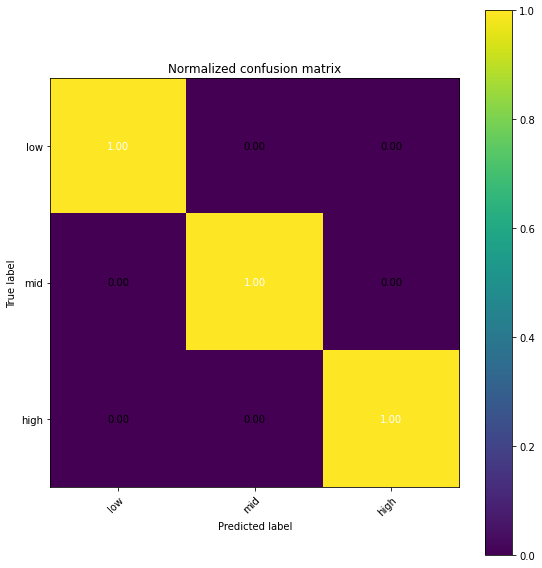

In [19]:
model = LogisticRegression(multi_class="multinomial", solver="lbfgs")
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
class_names = np.array(["low", "mid", "high"] )
plot_conf_mat(test_y, y_pred, class_names)

# Neural Network

**aa: Perché output size è 2, mentre invece nel dataset che carichi (tu carichi full_df) ci sono 3 labels?**

In [0]:
class MLP(nn.Module):
    
    def __init__(self, input_size:int=10, hidden:List[int]=[10, 20, 30], output_size:int = 2):
        super(MLP, self).__init__()
        #Your definition here
        
    def forward(self, x):
        #Your forward here
        y = F.softmax(y)
        return y
        
        

In [0]:
model = MLP(a, [b], c)     # Where a is the number of features, and c is the number of classes
model = model.double()
model.parameters()

NameError: ignored

In [0]:
criterion = nn.CrossEntropyLoss()

# Your optimizer here
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [0]:
batch_size = 32

train_dataset = TensorDataset(
    torch.from_numpy(train_x).double(), 
    torch.from_numpy(train_y))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = TensorDataset(
    torch.from_numpy(validation_x).double(), 
    torch.from_numpy(validation_y))
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)


test_dataset = TensorDataset(
    torch.from_numpy(test_x).double(), 
    torch.from_numpy(test_y))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [0]:
liveloss = PlotLosses()

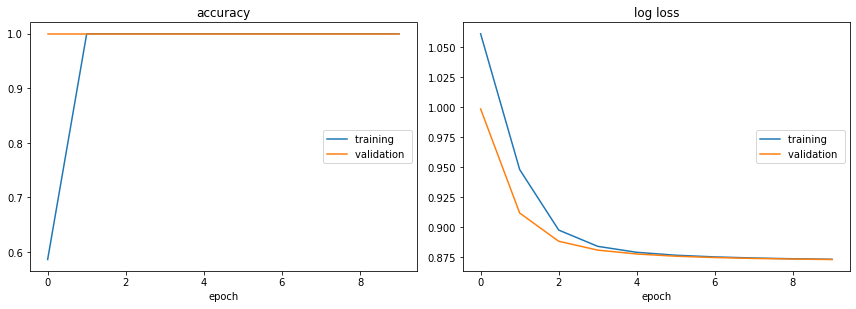

accuracy
	training         	 (min:    0.586, max:    1.000, cur:    1.000)
	validation       	 (min:    0.996, max:    1.000, cur:    1.000)
log loss
	training         	 (min:    0.871, max:    1.061, cur:    0.873)
	validation       	 (min:    0.871, max:    0.999, cur:    0.873)


In [0]:
epochs = 10

data_loader = {'train':train_loader, 'validation':validation_loader}

for epoch in range(epochs):  # loop over the dataset multiple times
    
    ####
    # Your training here
    ####
    
    
    epoch_loss = running_loss / len(data_loader[phase].dataset)
    logs[prefix + 'log loss'] = epoch_loss.item()
    epoch_acc = running_corrects.float() / len(data_loader[phase].dataset)
    logs[prefix + 'accuracy'] = epoch_acc.item()
    
    liveloss.update(logs)
    liveloss.draw()

In [0]:
# Your evaluation here

model.eval()

running_loss = 0.0
running_corrects = 0
for i, batch in enumerate(test_loader):
    x, y = batch
    y_pred = model(x)
    _, y_pred = torch.max(y_pred.detach(), 1)
    running_corrects += torch.sum(y_pred == y)

acc = running_corrects.float() / len(data_loader[phase].dataset)
print(acc)


tensor(1.)


<ipython-input-34-e9c7a85e67d8>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(y)
